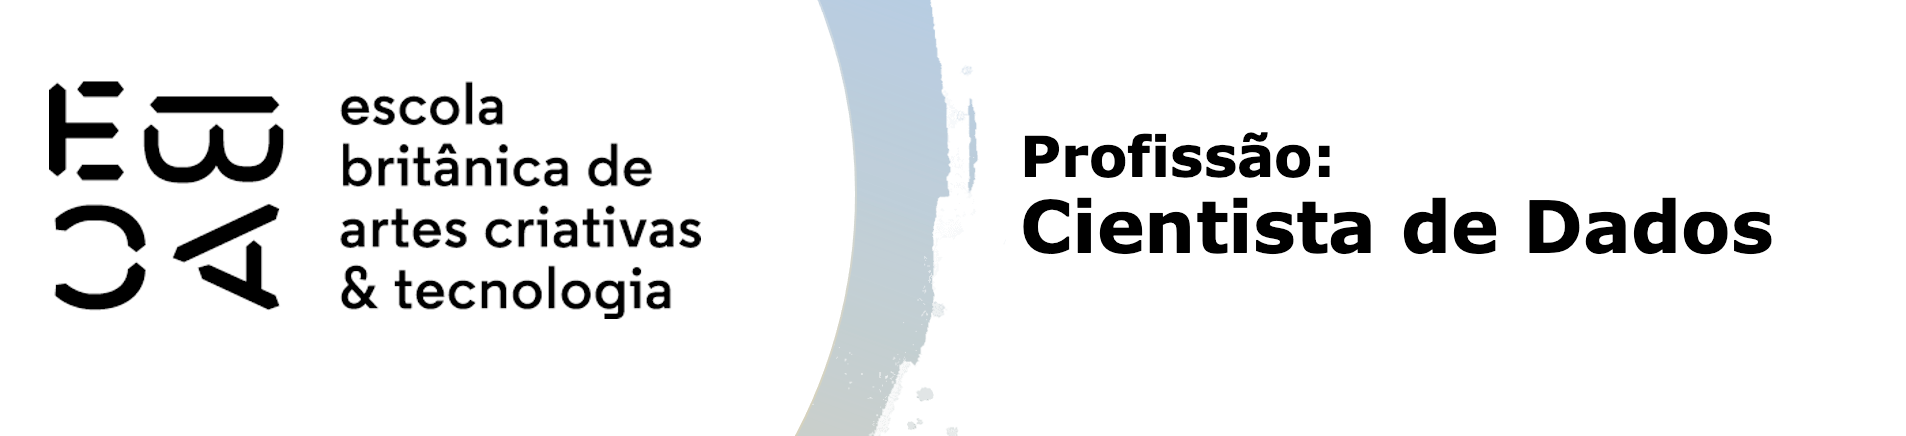

# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

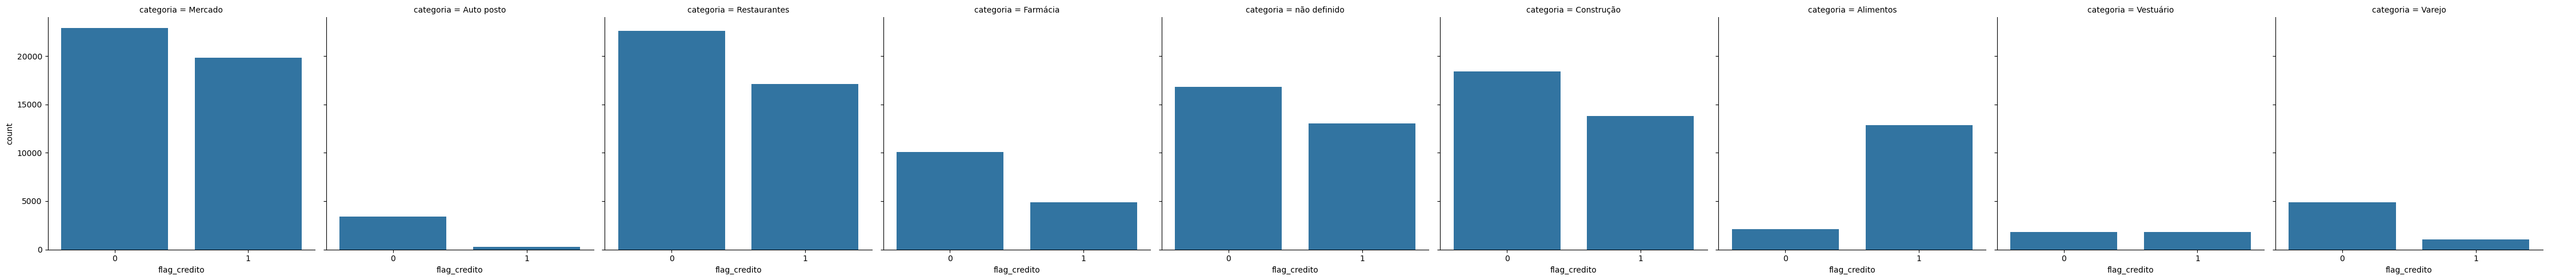

In [8]:
categorias = df['categoria'].unique()

sns.catplot(data=df,x='flag_credito', kind='count', col='categoria')
    

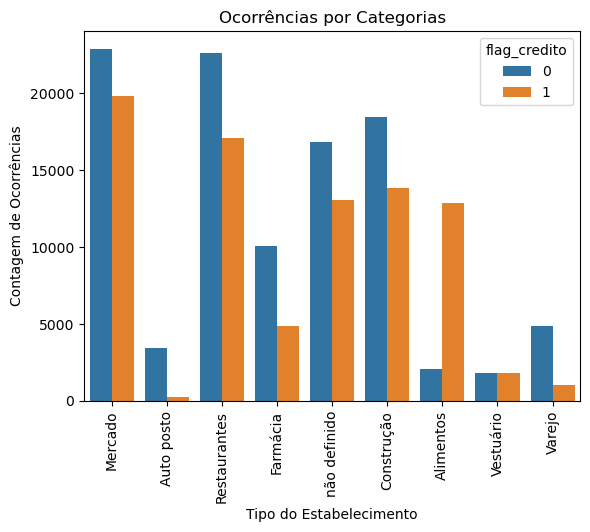

In [9]:
sns.countplot(data=df, x='categoria', hue='flag_credito')
plt.xticks(rotation=90)
plt.title('Ocorrências por Categorias')
plt.ylabel('Contagem de Ocorrências')
plt.xlabel('Tipo do Estabelecimento')
plt.show()


## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

##### Para esta etapa, precisaremos adicionar na nossa tabela os valores totais de empresas em cada categoria, para que assim, possamos comparar a ocorrência nesta categoria com as ocorrências totais. Assim sendo:

In [31]:
tab = pd.crosstab(df['flag_credito'], df['categoria'])
tab['total'] = tab.sum(axis=1)

tabT= tab.T
total_refuse = tabT.loc['total', 0]
total_approve = tabT.loc['total', 1]
tabT['refuse_rate'] = tabT[0]/total_refuse
tabT['approve_rate'] = tabT[1]/total_approve
tabT['WOE'] = np.log(tabT['approve_rate']/tabT['refuse_rate'])

# Segue abaixo a visualização da nossa tabela com os ratios e o WOE:
tabT

flag_credito,0,1,refuse_rate,approve_rate,WOE
categoria,,,,,
Alimentos,2092,12868,0.020309,0.152036,2.013046
Auto posto,3418,271,0.033182,0.003202,-2.338269
Construção,18425,13811,0.178870,0.163177,-0.091820
Farmácia,10054,4886,0.097604,0.057728,-0.525173
Mercado,22887,19808,0.222187,0.234032,0.051940
Restaurantes,22631,17118,0.219701,0.202250,-0.082767
Varejo,4869,1035,0.047268,0.012229,-1.352064
Vestuário,1813,1799,0.017601,0.021255,0.188671
não definido,16819,13042,0.163279,0.154092,-0.057911


#### Podemos também fazer uma visualização gráfica da situação, segue abaixo:


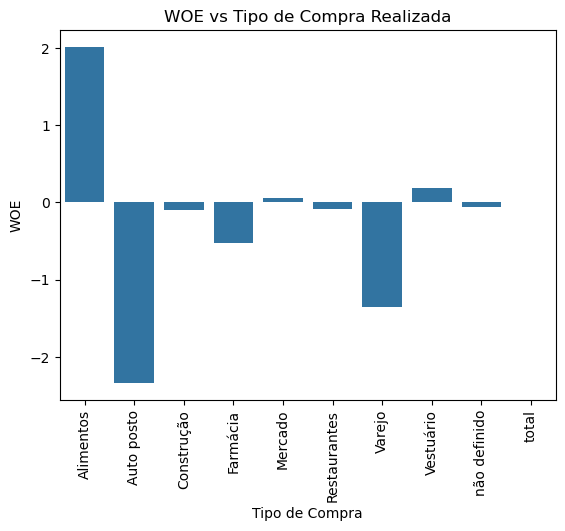

In [39]:
sns.barplot(data=tabT, x=tabT.index, y='WOE')
plt.title('WOE vs Tipo de Compra Realizada')
plt.xticks(rotation=90)
plt.xlabel('Tipo de Compra')
plt.ylabel('WOE')
plt.show()

#### O gráfico acima mostra que a variável que melhor discrimina a compra ou não compra é a compra de alimentos, a qual tem disparadamente o maior WOE.

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [14]:
s=0
for i in range(0, tabT.shape[0]):
    s += (tabT.iloc[i, 3] - tabT.iloc[i, 2])*tabT.iloc[i, 4]

InformationValue = s

print(f'O valor do Information Value é {InformationValue}')
print('Portanto, o poder preditivo da nossa categoria é MUITO BOM.')

O valor do Information Value é 0.40831279222730105
Portanto, o poder preditivo da nossa categoria é MUITO BOM.


## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


<font color='green'>**Alguns fatores são importantes de serem destacados. Primeiro: dado o IV maior que .4, a nossa categoria possui alto valor preditivo. Segundo: as categorias com maior chance de retorno são Mercado e Restaurantes. São as variáveis mais adequadas quando se quer tentar garantir que o retorno exista. Agora, existe outro ponto importante: embora garanta que o retorno exista, o retorno desses estabelecimentos em tese poderia ser próximo de nulo. Convém levarmos em consideração outra métrica: a média do retorno de cada categoria. Para tanto, vejamos:.**</font> 

In [17]:
gb_categoria = df.groupby('categoria')['Retorno'].mean()
gb_categoria

categoria
Alimentos       0.161869
Auto posto      0.005623
Construção      0.184331
Farmácia        0.035293
Mercado         0.099707
Restaurantes    0.034218
Varejo          0.058986
Vestuário       0.164244
não definido    0.187369
Name: Retorno, dtype: float64

<font color='blue'>**Assim podemos ver que embora não sejam os componente com maior CHANCE de retorno,  Alimentos, Construção e Vestuário são os componentes com maior PERCENTUAL de retorno. Devido ao gap relativamente baixo entre as CHANCES de retorno e o gap bem alto entre o PERCENTUAL de retorno, é seguro afirmar que, visando-se obter maior crédito médio por valor investido, é muito mais válido fazer compras em Construção. Já vestuário, embora tenha altos índices de retorno, tem baixíssimos índices de aprovação, não sendo uma escolha muito viável.**</font> 